In [ ]:
pip install praw

In [1]:
import praw
import pandas as pd
from datetime import datetime, timedelta, timezone

# --- YOUR API CREDENTIALS HERE ---
reddit = praw.Reddit(
    client_id="HyQsjZl6wPb1e5_b3ztY-Q",
    client_secret="Nnbso4_IlsNKG2xDbIuFBYwuQbVfuA",
    user_agent="MySentimentScript by u/vishnu"
)

# --- CONFIG ---
SUBREDDITS = ['wallstreetbets', 'IndiaInvestments']
KEYWORDS = ['Tesla', 'TSLA', 'Nifty', 'Sensex', 'NSE', 'India market']
DAYS_BACK = 180
LIMIT = 1000

# --- SCRAPE ---
all_posts = []

for subreddit in SUBREDDITS:
    print(f"Scraping: r/{subreddit}")
    for post in reddit.subreddit(subreddit).new(limit=LIMIT):
        post_time = datetime.fromtimestamp(post.created_utc, tz=timezone.utc)
        if post_time < datetime.now(timezone.utc) - timedelta(days=DAYS_BACK):
            continue

        text = (post.title + " " + post.selftext).lower()
        if any(keyword.lower() in text for keyword in KEYWORDS):
            all_posts.append({
                'date': post_time.date(),
                'title': post.title,
                'content': post.selftext,
                'url': post.url,
                'subreddit': subreddit
            })

# --- SAVE ---
df = pd.DataFrame(all_posts)
print(f"✅ Scraped {len(df)} posts")
df.to_csv("reddit_sentiment_data.csv", index=False)


Scraping: r/wallstreetbets
Scraping: r/IndiaInvestments
✅ Scraped 175 posts


🔥 PHASE 3: News Headline Scraper
Perfect. Now let’s build the news headline scraping module using NewsAPI to fetch headlines about:

Tesla

Nifty 50 / Indian markets

For the last 6 months



In [2]:
pip install newsapi-python

In [2]:
from newsapi import NewsApiClient
import pandas as pd
from datetime import datetime, timedelta

# --- CONFIG ---
API_KEY = 'YOUR_NEWSAPI_KEY'  # ← Replace this
newsapi = NewsApiClient(api_key="5ad34289e95c419e817756060ac2d7a4")

KEYWORDS = ['Tesla', 'TSLA', 'Nifty 50', 'India Market', 'Sensex', 'NSE']
DAYS_BACK = 28
LANGUAGE = 'en'
PAGE_SIZE = 100  # Max per request

# --- DATE RANGE ---
to_date = datetime.today()
from_date = to_date - timedelta(days=DAYS_BACK)

# --- COLLECT HEADLINES ---
all_articles = []

for keyword in KEYWORDS:
    print(f"🔍 Searching news for: {keyword}")
    for page in range(1, 6):  # 5 pages * 100 results = 500 max per keyword
        try:
            articles = newsapi.get_everything(
                q=keyword,
                from_param=from_date.strftime('%Y-%m-%d'),
                to=to_date.strftime('%Y-%m-%d'),
                language=LANGUAGE,
                sort_by='relevancy',
                page=page,
                page_size=PAGE_SIZE
            )

            if not articles['articles']:
                break

            for article in articles['articles']:
                all_articles.append({
                    'date': article['publishedAt'][:10],
                    'title': article['title'],
                    'content': article['description'] or "",
                    'source': article['source']['name'],
                    'url': article['url'],
                    'keyword': keyword
                })
        except Exception as e:
            print(f"❌ Error fetching page {page} for {keyword}: {e}")
            break

print(f"\n✅ Total articles fetched: {len(all_articles)}")

# --- SAVE TO CSV ---
df_news = pd.DataFrame(all_articles)
df_news.to_csv("newsapi_tesla_nifty.csv", index=False)


🔍 Searching news for: Tesla
❌ Error fetching page 2 for Tesla: {'status': 'error', 'code': 'maximumResultsReached', 'message': 'You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results.'}
🔍 Searching news for: TSLA
❌ Error fetching page 2 for TSLA: {'status': 'error', 'code': 'maximumResultsReached', 'message': 'You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results.'}
🔍 Searching news for: Nifty 50
❌ Error fetching page 2 for Nifty 50: {'status': 'error', 'code': 'maximumResultsReached', 'message': 'You have requested too many results. Developer accounts are limited to a max of 100 results. You are trying to request results 100 to 200. Please upgrade to a paid plan if you need more results.'}
🔍 Searching news for:

Next step: Use FinBERT to classify the sentiment (Positive / Negative / Neutral) of each headline or Reddit post.

🧠 What Is FinBERT?
FinBERT is a financial-domain fine-tuned BERT model. It’s specifically trained on finance-related text (e.g., earnings calls, financial news), so it's perfect for this use case.



In [ ]:
pip install transformers

In [ ]:
pip install torch

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

c:\Users\vishnu vardhan\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vishnu vardhan\.cache\huggingface\hub\models--yiyanghkust--finbert-tone. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cpu


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [4]:
print(finbert("The Indian market looks very risky today."))

[{'label': 'Negative', 'score': 0.9827950596809387}]


In [5]:
import pandas as pd

reddit_df = pd.read_csv("reddit_sentiment_data.csv")
news_df = pd.read_csv("newsapi_tesla_nifty.csv")


In [7]:
# Combine title + content
# Combine title + content safely
MAX_LEN = 1000  # characters, not tokens
reddit_df["text"] = (reddit_df["title"].fillna('') + ". " + reddit_df["content"].fillna('')).str[:MAX_LEN]
news_df["text"] = (news_df["title"].fillna('') + ". " + news_df["content"].fillna('')).str[:MAX_LEN]


# Run in batches for performance
def analyze_sentiment(texts):
    return finbert(texts)

# Batch processing
def batch_sentiment(df, text_col="text", batch_size=32):
    sentiments = []
    for i in range(0, len(df), batch_size):
        batch = df[text_col].iloc[i:i+batch_size].tolist()
        results = analyze_sentiment(batch)
        sentiments.extend(results)
    return sentiments

# Apply to Reddit
reddit_results = batch_sentiment(reddit_df)
reddit_df["sentiment"] = [r["label"] for r in reddit_results]
reddit_df["confidence"] = [r["score"] for r in reddit_results]

# Apply to News
news_results = batch_sentiment(news_df)
news_df["sentiment"] = [r["label"] for r in news_results]
news_df["confidence"] = [r["score"] for r in news_results]


In [39]:
reddit_df.to_csv("reddit_sentiment_labeled.csv", index=False)
news_df.to_csv("news_sentiment_labeled.csv", index=False)


Step 4: Topic Tagging – Tesla vs Nifty

In [9]:
TESLA_KEYWORDS = ["tesla", "tsla", "elon"]
NIFTY_KEYWORDS = ["nifty", "nse", "india", "sensex", "indian"]


In [10]:
def identify_topic(text):
    text = text.lower()
    tesla_found = any(word in text for word in TESLA_KEYWORDS)
    nifty_found = any(word in text for word in NIFTY_KEYWORDS)
    
    if tesla_found and nifty_found:
        return "Both"
    elif tesla_found:
        return "Tesla"
    elif nifty_found:
        return "Nifty"
    else:
        return "Unknown"


In [11]:
reddit_df["topic"] = reddit_df["text"].apply(identify_topic)
news_df["topic"] = news_df["text"].apply(identify_topic)


In [12]:
print(reddit_df["topic"].value_counts())
print(news_df["topic"].value_counts())


topic
Nifty      102
Tesla       48
Unknown     22
Both         3
Name: count, dtype: int64
topic
Nifty      321
Tesla      176
Unknown    101
Both         2
Name: count, dtype: int64


In [38]:
reddit_df.to_csv("reddit_sentiment_labeled.csv", index=False)
news_df.to_csv("news_sentiment_labeled.csv", index=False)


In [14]:
import yfinance as yf
import pandas as pd


In [40]:
print(daily_sentiment_pivot.head(10))
print(daily_sentiment_pivot.dtypes)
print(daily_sentiment_pivot["date"].min(), daily_sentiment_pivot["date"].max())


         date  Both  Nifty  Tesla  Unknown
0  2024-12-15   NaN    NaN    NaN      NaN
1  2024-12-20   NaN    NaN    NaN      NaN
2  2024-12-22   NaN    NaN    NaN      NaN
3  2024-12-29   NaN    NaN    NaN      NaN
4  2025-01-01   NaN    NaN    NaN      NaN
5  2025-01-04   NaN    NaN    NaN      NaN
6  2025-01-05   NaN    NaN    NaN      NaN
7  2025-01-12   NaN    NaN    NaN      NaN
8  2025-01-15   NaN    NaN    NaN      NaN
9  2025-01-18   NaN    NaN    NaN      NaN
date        object
Both       float64
Nifty      float64
Tesla      float64
Unknown    float64
dtype: object
2024-12-15 2025-06-11


In [42]:
# 1. Set correct range based on sentiment dates
start_date = "2024-12-01"
end_date = "2025-06-11"

# 2. Download updated price data
tesla_df = yf.download("TSLA", start=start_date, end=end_date)[["Close"]].reset_index()
tesla_df.columns = ["date", "tesla_close"]

nifty_df = yf.download("^NSEI", start=start_date, end=end_date)[["Close"]].reset_index()
nifty_df.columns = ["date", "nifty_close"]

# 3. Convert price data to datetime.date
tesla_df["date"] = pd.to_datetime(tesla_df["date"]).dt.date
nifty_df["date"] = pd.to_datetime(nifty_df["date"]).dt.date

# 4. Prepare sentiment scores
# Map sentiment labels to numeric values
sentiment_map = {"positive": 1, "neutral": 0, "negative": -1}
# Normalize case before mapping
combined_df["sentiment_score"] = combined_df["sentiment"].str.lower().map(sentiment_map)


# 5. Group by date and topic to get average daily sentiment
# Rebuild daily sentiment mean per topic
daily_sentiment = combined_df.groupby(["date", "topic"])["sentiment_score"].mean().reset_index()

# Pivot to wide format
daily_sentiment_pivot = daily_sentiment.pivot(index="date", columns="topic", values="sentiment_score").reset_index()
daily_sentiment_pivot.columns.name = None


# 7. Ensure dates are datetime.date (to match yfinance)
trading_dates = set(tesla_df["date"])
daily_sentiment_pivot = daily_sentiment_pivot[daily_sentiment_pivot["date"].isin(trading_dates)]


# 8. Merge all data using inner join to get only common trading days
merged = tesla_df.merge(nifty_df, on="date", how="inner")
merged = merged.merge(daily_sentiment_pivot, on="date", how="left")


# 9. Save final merged file and inspect
merged.to_csv("merged_sentiment_price.csv", index=False)
print(merged.head())
print("Shape of merged data:", merged.shape, merged.isnull().sum())


C:\Users\vishnu vardhan\AppData\Local\Temp\ipykernel_19044\1477001693.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tesla_df = yf.download("TSLA", start=start_date, end=end_date)[["Close"]].reset_index()
[*********************100%***********************]  1 of 1 completed
C:\Users\vishnu vardhan\AppData\Local\Temp\ipykernel_19044\1477001693.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty_df = yf.download("^NSEI", start=start_date, end=end_date)[["Close"]].reset_index()
[*********************100%***********************]  1 of 1 completed

         date  tesla_close   nifty_close  Both  Nifty  Tesla  Unknown
0  2024-12-02   357.089996  24276.050781   NaN    NaN    NaN      NaN
1  2024-12-03   351.420013  24457.150391   NaN    NaN    NaN      NaN
2  2024-12-04   357.929993  24467.449219   NaN    NaN    NaN      NaN
3  2024-12-05   369.489990  24708.400391   NaN    NaN    NaN      NaN
4  2024-12-06   389.220001  24677.800781   NaN    NaN    NaN      NaN
Shape of merged data: (124, 7) date             0
tesla_close      0
nifty_close      0
Both           119
Nifty           86
Tesla          105
Unknown        104
dtype: int64


In [43]:
print(merged.head())
print("Shape of merged data:", merged.shape, merged.isnull().sum())

         date  tesla_close   nifty_close  Both  Nifty  Tesla  Unknown
0  2024-12-02   357.089996  24276.050781   NaN    NaN    NaN      NaN
1  2024-12-03   351.420013  24457.150391   NaN    NaN    NaN      NaN
2  2024-12-04   357.929993  24467.449219   NaN    NaN    NaN      NaN
3  2024-12-05   369.489990  24708.400391   NaN    NaN    NaN      NaN
4  2024-12-06   389.220001  24677.800781   NaN    NaN    NaN      NaN
Shape of merged data: (124, 7) date             0
tesla_close      0
nifty_close      0
Both           119
Nifty           86
Tesla          105
Unknown        104
dtype: int64


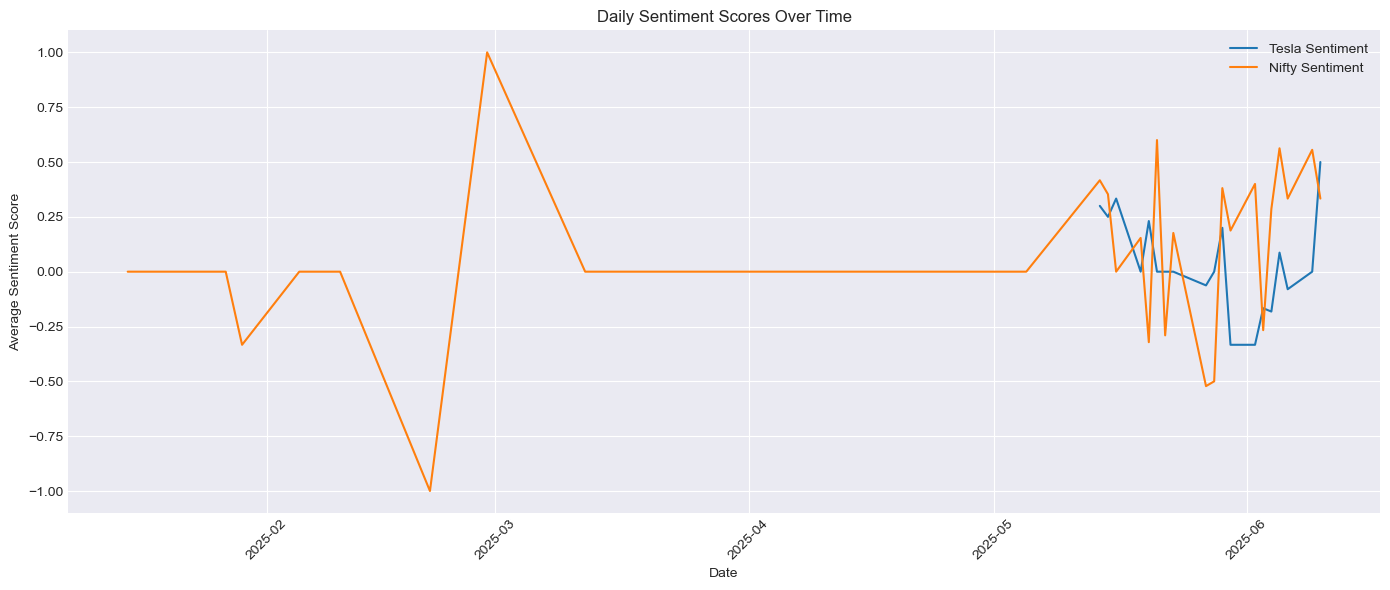

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use("seaborn-v0_8-darkgrid")
plt.figure(figsize=(14, 6))

# Plot sentiment scores
sns.lineplot(data=merged, x="date", y="Tesla", label="Tesla Sentiment")
sns.lineplot(data=merged, x="date", y="Nifty", label="Nifty Sentiment")

plt.title("Daily Sentiment Scores Over Time")
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [45]:
# Only use rows with valid sentiment
corr_df = merged[["Tesla", "Nifty", "tesla_close", "nifty_close"]].dropna()

# Correlation matrix
correlation = corr_df.corr()

print("Correlation matrix:")
print(correlation)


Correlation matrix:
                Tesla     Nifty  tesla_close  nifty_close
Tesla        1.000000  0.085355     0.016509     0.451956
Nifty        0.085355  1.000000    -0.556519     0.364252
tesla_close  0.016509 -0.556519     1.000000    -0.267146
nifty_close  0.451956  0.364252    -0.267146     1.000000


In [46]:
# Create a lagged version of sentiment scores (yesterday's sentiment)
merged["Tesla_lag"] = merged["Tesla"].shift(1)
merged["Nifty_lag"] = merged["Nifty"].shift(1)

# Drop rows with NaNs caused by shift
lagged_df = merged.dropna(subset=["Tesla_lag", "Nifty_lag", "tesla_close", "nifty_close"])

# Calculate lag correlation
lag_correlation = lagged_df[["Tesla_lag", "Nifty_lag", "tesla_close", "nifty_close"]].corr()

print("Lagged Correlation Matrix:\n", lag_correlation)


Lagged Correlation Matrix:
              Tesla_lag  Nifty_lag  tesla_close  nifty_close
Tesla_lag     1.000000   0.026787     0.166699     0.546417
Nifty_lag     0.026787   1.000000    -0.375534     0.226736
tesla_close   0.166699  -0.375534     1.000000    -0.246930
nifty_close   0.546417   0.226736    -0.246930     1.000000


📈 Backtesting Strategy Plan

✅ Strategy:
If Tesla sentiment on day t-1 > 0, buy and hold Tesla for day t (i.e., assume we act on yesterday’s sentiment).

Likewise, if Nifty sentiment on day t-1 > 0, buy Nifty for day t.

Track daily returns from this strategy and compare it to buy-and-hold.

In [55]:
import numpy as np

# 1. Sort data
merged.sort_values("date", inplace=True)
merged.reset_index(drop=True, inplace=True)

# 2. Compute daily returns
merged["tesla_return"] = merged["tesla_close"].pct_change()
merged["nifty_return"] = merged["nifty_close"].pct_change()

# 3. Shift sentiment by 1 day to simulate "acting on yesterday’s sentiment"
merged["Tesla_signal"] = merged["Tesla"].shift(1)
merged["Nifty_signal"] = merged["Nifty"].shift(1)

# 4. Strategy returns: only invest when signal > 0
merged["tesla_strategy_return"] = merged["tesla_return"] * (merged["Tesla_signal"] > 0)
merged["nifty_strategy_return"] = merged["nifty_return"] * (merged["Nifty_signal"] > 0)

# 5. Cumulative returns
merged["tesla_cum_strategy"] = (1 + merged["tesla_strategy_return"]).cumprod()
merged["tesla_cum_buyhold"] = (1 + merged["tesla_return"]).cumprod()

merged["nifty_cum_strategy"] = (1 + merged["nifty_strategy_return"]).cumprod()
merged["nifty_cum_buyhold"] = (1 + merged["nifty_return"]).cumprod()

# 6. Final returns
final_tesla_strategy = merged["tesla_cum_strategy"].iloc[-1]
final_tesla_buyhold = merged["tesla_cum_buyhold"].iloc[-1]

final_nifty_strategy = merged["nifty_cum_strategy"].iloc[-1]
final_nifty_buyhold = merged["nifty_cum_buyhold"].iloc[-1]

print("Tesla Strategy Final Return: {:.2f}%".format((final_tesla_strategy - 1) * 100))
print("Tesla Buy & Hold Return: {:.2f}%".format((final_tesla_buyhold - 1) * 100))

print("Nifty Strategy Final Return: {:.2f}%".format((final_nifty_strategy - 1) * 100))
print("Nifty Buy & Hold Return: {:.2f}%".format((final_nifty_buyhold - 1) * 100))


Tesla Strategy Final Return: -4.04%
Tesla Buy & Hold Return: -8.68%
Nifty Strategy Final Return: 0.18%
Nifty Buy & Hold Return: 3.41%


In [ ]:
# GAPPPP

In [ ]:
pip install yfinance